In [20]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
import os

## Leitura e limpeza do csv com colunas específicas

In [21]:
def leitor_csv_zip(caminho_zip: str, colunas: list[str]) -> pd.DataFrame:
    """
    Lê um CSV de dentro de um arquivo .zip, usando apenas as colunas necessárias.
    """
    try:
        with zipfile.ZipFile(caminho_zip, 'r') as z:
            # lista todos os arquivos dentro do zip
            arquivos = z.namelist()
            # pega só os que terminam com .csv
            csvs = [arq for arq in arquivos if arq.lower().endswith(".csv")]

            if not csvs:
                print(f"Nenhum arquivo .csv encontrado dentro de {caminho_zip}")
                return pd.DataFrame()

            # por simplicidade, vamos usar o primeiro CSV encontrado
            csv_principal = csvs[0]
            print(f"Lendo {csv_principal} de dentro de {caminho_zip}")

            with z.open(csv_principal) as f:
                quadro = pd.read_csv(f, usecols=colunas, low_memory=False)

        # Padroniza colunas para minúsculas, igual ao leitor de .csv solto
        quadro.columns = [c.lower() for c in quadro.columns]
        return quadro

    except Exception as e:
        print(f"Erro ao ler {caminho_zip}: {e}")
        return pd.DataFrame()


def leitor_geral_especifico_zip(caminhos_zip: list[str], colunas: list[str]) -> pd.DataFrame:
    """
    Lê vários .zip (cada um contendo um CSV de dengue) e concatena tudo em um único DataFrame.
    """
    dados_finais = pd.DataFrame()

    for caminho in caminhos_zip:
        quadro = leitor_csv_zip(caminho, colunas)
        if not quadro.empty:
            dados_finais = pd.concat([dados_finais, quadro], ignore_index=True)

    print(f"Total de linhas após leitura geral (zip): {len(dados_finais)}")
    print(f"Colunas do DataFrame final: {list(dados_finais.columns)}")
    return dados_finais

def converter_datas(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Converte DT_SIN_PRI e DT_NOTIFIC para datetime.
    """
    if "dt_sin_pri" in quadro.columns:
        quadro["dt_sin_pri"] = pd.to_datetime(
            quadro["dt_sin_pri"],
            errors="coerce"
        )

    if "dt_notific" in quadro.columns:
        quadro["dt_notific"] = pd.to_datetime(
            quadro["dt_notific"],
            errors="coerce"
        )

    return quadro

def filtrar_ano_minimo(quadro: pd.DataFrame, ano_minimo: int = 2020) -> pd.DataFrame:
    """
    Remove linhas com NU_ANO menor que 'ano_minimo' (padrão: 2020).

    Útil para descartar notificações de 2019 que aparecem no CSV de 2020,
    mas que não queremos considerar na análise 2020–2025.
    """
    if "nu_ano" not in quadro.columns:
        print("Aviso: coluna 'nu_ano' não encontrada. Nenhum filtro de ano aplicado.")
        return quadro

    # Garante que nu_ano é numérico
    quadro["nu_ano"] = pd.to_numeric(quadro["nu_ano"], errors="coerce")

    antes = len(quadro)
    quadro_filtrado = quadro[quadro["nu_ano"] >= ano_minimo].copy()
    depois = len(quadro_filtrado)

    print(f"Filtrar ano >= {ano_minimo}: {antes} -> {depois} linhas.")
    return quadro_filtrado

## Filtragem classificados com dengue

In [22]:
# Remove casos com classi_fin considerado descartado
def filtrar_classificados(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Remove casos descartados (CLASSI_FIN == 5).
    """
    if "classi_fin" not in quadro.columns:
        print("Aviso: coluna 'classi_fin' não encontrada. Nenhum filtro aplicado.")
        return quadro

    quadro["classi_fin"] = pd.to_numeric(quadro["classi_fin"], errors="coerce")
    antes = len(quadro)
    quadro_filtrado = quadro[quadro["classi_fin"] != 5].copy()
    depois = len(quadro_filtrado)

    print(f"Filtrar classificados: {antes} -> {depois} linhas (descartados removidos).")
    return quadro_filtrado

## Contagem semanal e anual do Brasil

In [23]:
def contagem_semanal_brasil(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Retorna um DataFrame com o número de casos por ano e semana epidemiológica
    para todo o Brasil (sem filtro por UF).
    Espera colunas: 'nu_ano' e 'sem_not'.
    """
    df = quadro.copy()

    # Garantir que sem_not é numérico e não nulo
    df = df[df["sem_not"].notna()]
    df["sem_not"] = pd.to_numeric(df["sem_not"], errors="coerce")
    df = df[df["sem_not"].notna()]

    # Extrair semana epidemiológica (últimos 2 dígitos, ex: 202415 -> 15)
    df["semana_ep"] = (df["sem_not"] % 100).astype(int)

    semana = (
        df.groupby(["nu_ano", "semana_ep"], as_index=False)
          .size()
          .rename(columns={"size": "casos"})
    )

    return semana


def contagem_anual_brasil(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Retorna um DataFrame com o número total de casos por ano para todo o Brasil.
    Espera coluna 'nu_ano'.
    """
    df = quadro.copy()

    ano = (
        df.groupby("nu_ano", as_index=False)
          .size()
          .rename(columns={"size": "casos"})
    )

    return ano

## Resumo temporal por ano

In [24]:
def resumo_temporal_por_ano(semana_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Recebe o DataFrame de contagem semanal (nu_ano, semana_ep, casos)
    e calcula estatísticas descritivas da série de 'casos' POR ANO.
    """
    if semana_df.empty:
        return pd.DataFrame(), pd.DataFrame()

    def _estatisticas(g: pd.DataFrame) -> pd.Series:
        serie = g["casos"]
        media = serie.mean()
        mediana = serie.median()
        moda = serie.mode().tolist()
        desvio = serie.std()
        iqr_val = iqr(serie, nan_policy="omit")
        return pd.Series({
            "media": media,
            "mediana": mediana,
            "moda": moda[0] if len(moda) > 0 else None,
            "desvio_padrao": desvio,
            "iqr": iqr_val,
        })

    resumo = (
        semana_df
        .groupby("nu_ano")
        .apply(_estatisticas)
        .reset_index()
    )

    # Calcular outliers por ano
    lista_outliers = []
    for ano, g in semana_df.groupby("nu_ano"):
        serie = g["casos"]
        q1, q3 = serie.quantile([0.25, 0.75])
        lim_inf = q1 - 1.5 * (q3 - q1)
        lim_sup = q3 + 1.5 * (q3 - q1)
        out = g[(g["casos"] < lim_inf) | (g["casos"] > lim_sup)].copy()
        out["nu_ano"] = ano
        lista_outliers.append(out)

    outliers = (
        pd.concat(lista_outliers, ignore_index=True)
        if lista_outliers else pd.DataFrame()
    )

    return resumo, outliers

## Graficos

In [25]:
def grafico_linha_semanal_brasil(semana_df: pd.DataFrame):
    """
    Plota a evolução semanal dos casos de dengue no Brasil,
    com uma linha por ano (nu_ano), usando semana_ep (1–52/53).
    """
    if semana_df.empty:
        print("DataFrame semanal vazio – nenhum gráfico gerado.")
        return

    semana_df = semana_df.sort_values(["nu_ano", "semana_ep"])

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=semana_df,
        x="semana_ep",
        y="casos",
        hue="nu_ano",
        marker="o"
    )

    plt.title("Evolução semanal dos casos de dengue – Brasil (2020–2025)")
    plt.xlabel("Semana epidemiológica")
    plt.ylabel("Número de casos")
    plt.xticks(
        range(1, semana_df["semana_ep"].max() + 1, 2)
    )
    plt.legend(title="Ano")
    plt.tight_layout()
    plt.show()


def grafico_barras_anual_brasil(ano_df: pd.DataFrame):
    """
    Plota um gráfico de barras com o total anual de casos no Brasil.
    """
    if ano_df.empty:
        print("DataFrame anual vazio – nenhum gráfico gerado.")
        return

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=ano_df,
        x="nu_ano",
        y="casos"
    )

    plt.title("Total anual de casos de dengue – Brasil (2020–2025)")
    plt.xlabel("Ano")
    plt.ylabel("Número de casos")
    plt.tight_layout()
    plt.show()

## Gravidade por ano

In [26]:
def tabela_gravidade_por_ano_brasil(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Retorna uma tabela com contagem de casos por ano e por CLASSI_FIN
    para todo o Brasil (sem filtro de UF).

    CLASSI_FIN (segundo dicionário online):
        10 = Dengue
        11 = Dengue com sinais de alarme
        12 = Dengue grave
        8  = Outros / Síndrome febril inespecífica
    """
    df = quadro.copy()

    # Garantir numérico
    df["classi_fin"] = pd.to_numeric(df["classi_fin"], errors="coerce")

    # Contagem por ano e classificação
    contagem = (
        df.groupby(["nu_ano", "classi_fin"], as_index=False)
          .size()
          .rename(columns={"size": "casos"})
    )

    # Pivotar para colunas por tipo
    tabela = contagem.pivot(index="nu_ano", columns="classi_fin", values="casos").fillna(0)
    tabela.reset_index(inplace=True)

    tabela_final = pd.DataFrame({
        "nu_ano": tabela["nu_ano"],
        "dengue":       tabela.get(10.0, 0),
        "sinal_alarme": tabela.get(11.0, 0),
        "grave":        tabela.get(12.0, 0),
        "outros":       tabela.get(8.0, 0),
    })

    tabela_final["total"] = (
        tabela_final["dengue"]
        + tabela_final["sinal_alarme"]
        + tabela_final["grave"]
        + tabela_final["outros"]
    )

    tabela_final["prop_grave"] = np.where(
        tabela_final["total"] > 0,
        tabela_final["grave"] / tabela_final["total"],
        0.0
    )

    tabela_final = tabela_final.sort_values("nu_ano").reset_index(drop=True)
    return tabela_final

## Grafico

In [27]:
def grafico_proporcao_graves_brasil(tabela_gravidade: pd.DataFrame):
    """
    Plota a proporção de casos graves por ano no Brasil.
    """
    if tabela_gravidade.empty:
        print("Tabela de gravidade vazia – nenhum gráfico gerado.")
        return

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=tabela_gravidade,
        x="nu_ano",
        y="prop_grave"
    )

    plt.title("Proporção de casos de dengue grave por ano – Brasil (2020–2025)")
    plt.xlabel("Ano")
    plt.ylabel("Proporção de casos graves")
    plt.tight_layout()
    plt.show()

## Execução completa

Lendo DENGBR20.csv de dentro de dados/DENGBR20.zip
Lendo DENGBR21.csv de dentro de dados/DENGBR21.zip
Lendo DENGBR22.csv de dentro de dados/DENGBR22.zip
Lendo DENGBR23.csv de dentro de dados/DENGBR23.zip
Lendo DENGBR24.csv de dentro de dados/DENGBR24.zip
Lendo DENGBR25.csv de dentro de dados/DENGBR25.zip
Total de linhas após leitura geral (zip): 13344402
Colunas do DataFrame final: ['dt_notific', 'sem_not', 'nu_ano', 'sg_uf_not', 'dt_sin_pri', 'nu_idade_n', 'cs_sexo', 'id_mn_resi', 'classi_fin']
Total de linhas após leitura geral (zip): 13344402
Colunas do DataFrame final: ['dt_notific', 'sem_not', 'nu_ano', 'sg_uf_not', 'dt_sin_pri', 'nu_idade_n', 'cs_sexo', 'id_mn_resi', 'classi_fin']
Filtrar classificados: 13344402 -> 12327380 linhas (descartados removidos).
Filtrar ano >= 2020: 12327380 -> 12323901 linhas.


C:\Users\guyar\AppData\Local\Temp\ipykernel_27108\2563151268.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_estatisticas)



Contagem anual no Brasil:
   nu_ano    casos
0    2020   952509
1    2021   531811
2    2022  1394532
3    2023  1508934
4    2024  6436073
5    2025  1500042

Resumo estatístico por ano – Brasil:
   nu_ano          media  mediana     moda  desvio_padrao        iqr
0    2021   10218.000000   8426.5   2305.0    7164.712424   10878.50
1    2022   26817.923077  12128.0   4029.0   29677.708836   31772.25
2    2023   29017.961538  14317.5   4324.0   29731.866412   33149.75
3    2024  123770.634615  33707.5   7202.0  144468.201475  242607.25
4    2025   55557.111111  61458.0  10619.0   25102.733971   36976.50

Outliers semanais por ano (semanas muito acima/abaixo do esperado):
   nu_ano  semana_ep   casos
0    2022         16   93029
1    2022         17  104450
2    2022         18   97672
3    2022         19   94698
4    2023         13   89611
5    2023         15  105977
6    2023         16   92324
7    2023         17   95176


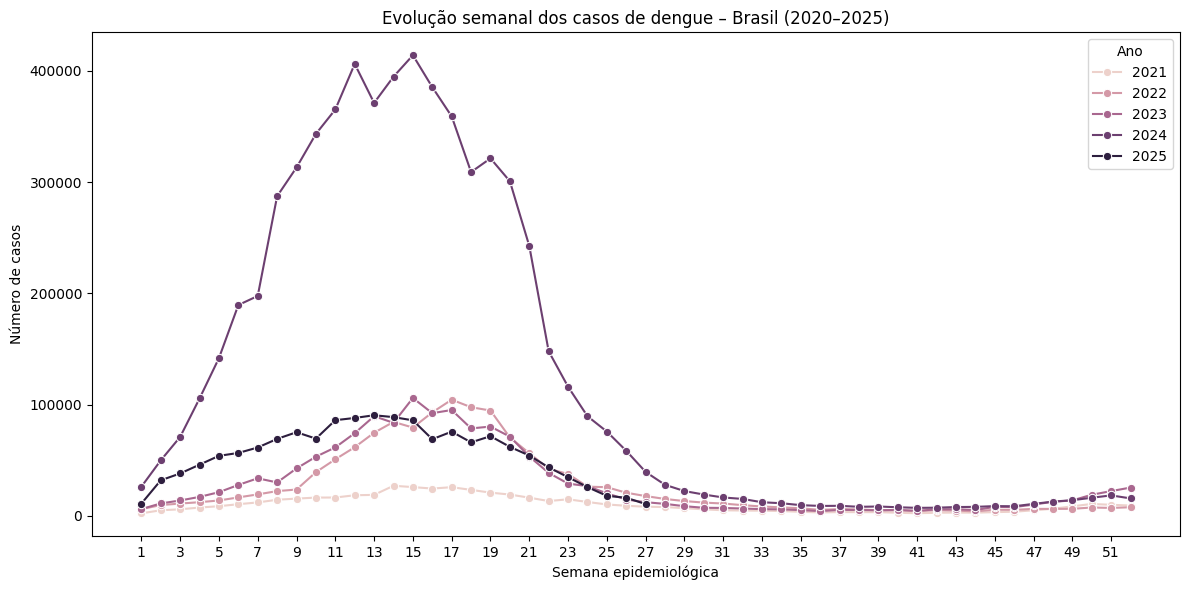

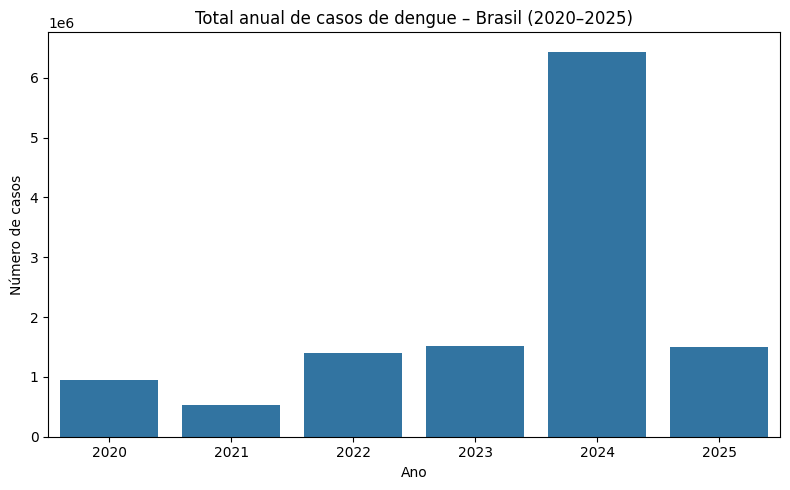


Tabela de gravidade por ano – Brasil:
   nu_ano   dengue  sinal_alarme  grave  outros    total  prop_grave
0    2020   779203          9526    925  161292   950946    0.000973
1    2021   442438          4838    440   83193   530909    0.000829
2    2022  1223671         18660   1541  149177  1393049    0.001106
3    2023  1276131         20120   1547  207752  1505550    0.001028
4    2024  5759692         98952   8690  560702  6428036    0.001352
5    2025  1182292         29735   2272  170611  1384910    0.001641


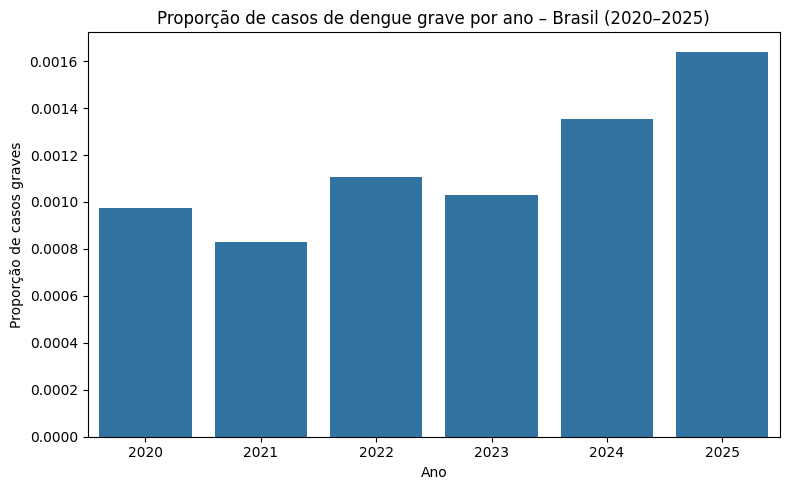

In [28]:
def executar_evolucao_e_gravidade_brasil(caminhos_zip: list[str], colunas_necessarias: list[str]):
    # 1) Ler e limpar
    dados = leitor_geral_especifico_zip(caminhos_zip, colunas_necessarias)
    print(f"Total de linhas após leitura geral (zip): {len(dados)}")
    print(f"Colunas do DataFrame final: {list(dados.columns)}")

    dados = converter_datas(dados)
    dados = filtrar_classificados(dados)
    dados = filtrar_ano_minimo(dados, ano_minimo=2020)

    # 2) Evolução temporal
    semana_br = contagem_semanal_brasil(dados)
    ano_br = contagem_anual_brasil(dados)

    resumo_ano, outliers = resumo_temporal_por_ano(semana_br)

    print("\nContagem anual no Brasil:")
    print(ano_br)

    print("\nResumo estatístico por ano – Brasil:")
    print(resumo_ano)

    print("\nOutliers semanais por ano (semanas muito acima/abaixo do esperado):")
    print(outliers)

    grafico_linha_semanal_brasil(semana_br)
    grafico_barras_anual_brasil(ano_br)

    # 3) Gravidade por ano
    tabela_grav = tabela_gravidade_por_ano_brasil(dados)

    print("\nTabela de gravidade por ano – Brasil:")
    print(tabela_grav)

    grafico_proporcao_graves_brasil(tabela_grav)


caminhos_zip = [
    "dados/DENGBR20.zip",
    "dados/DENGBR21.zip",
    "dados/DENGBR22.zip",
    "dados/DENGBR23.zip",
    "dados/DENGBR24.zip",
    "dados/DENGBR25.zip",
]

colunas_necessarias = [
    "DT_NOTIFIC",
    "SEM_NOT",
    "NU_ANO",
    "SG_UF_NOT",
    "DT_SIN_PRI",
    "NU_IDADE_N",
    "CS_SEXO",
    "CLASSI_FIN",
    "ID_MN_RESI"
]


executar_evolucao_e_gravidade_brasil(caminhos_zip, colunas_necessarias)